# DGCNN

In [7]:
# Always reload in jupyter notebook
%load_ext autoreload
%autoreload 2

import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from dgcnn.data import load_data_cls, load_data_partseg, load_data_semseg
from dgcnn.data import ModelNet40
from dgcnn.model import PointNet, DGCNN, DGCNN_partseg
from torch.utils.data import DataLoader
from dgcnn.util import cal_loss, IOStream
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Classification

In [8]:
X_train, y_train = load_data_cls('train')
X_test, y_test = load_data_cls('test')

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(9840, 2048, 3) (9840, 1)
(2468, 2048, 3) (2468, 1)


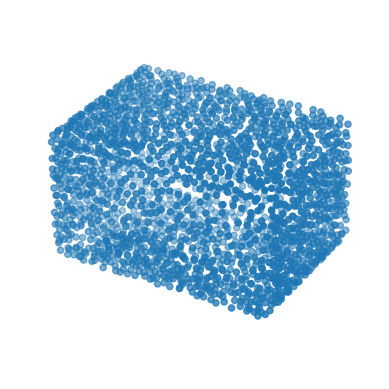

In [9]:
def plot_3d_shapes(X, y, ind):
    # Plot with the same scale for the axis
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(X[ind][:, 0], X[ind][:, 2], X[ind][:, 1])
    ax.set_aspect('equal', adjustable='box')
    ax.axis('off')
    plt.show()

plot_3d_shapes(X_train, y_train, 3)

## Training and Evaluation

In [2]:
def init_experiment(exp_name):
    if not os.path.exists('checkpoints'):
        os.makedirs('checkpoints')
    if not os.path.exists('checkpoints/'+exp_name):
        os.makedirs('checkpoints/'+exp_name)
    if not os.path.exists('checkpoints/'+exp_name+'/'+'models'):
        os.makedirs('checkpoints/'+exp_name+'/'+'models')
    return IOStream('checkpoints/'+exp_name+'/run.log')

def train(exp_name, model, epochs, batch_size, test_batch_size, num_points, io, lr=0.001):
    train_loader = DataLoader(ModelNet40(partition='train', num_points=num_points), num_workers=8,
                              batch_size=batch_size, shuffle=True, drop_last=True)
    test_loader = DataLoader(ModelNet40(partition='test', num_points=num_points), num_workers=8,
                             batch_size=test_batch_size, shuffle=True, drop_last=False)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    if device == torch.device('cuda'):
        model = nn.DataParallel(model)
        io.cprint("Let's use " + str(torch.cuda.device_count()) + " GPUs.")
    else:
        io.cprint("Using CPU.")
    model.to(device)

    opt = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = CosineAnnealingLR(opt, epochs, eta_min=lr) 
    criterion = cal_loss

    best_test_acc = 0
    for epoch in range(epochs):
        ####################
        # Train
        ####################
        train_loss = 0.0
        count = 0.0
        model.train()
        train_pred = []
        train_true = []
        for data, label in train_loader:
            data, label = data.to(device), label.to(device).squeeze()
            data = data.permute(0, 2, 1)
            batch_size = data.size()[0]
            opt.zero_grad()
            logits = model(data)
            loss = criterion(logits, label)
            loss.backward()
            opt.step()
            preds = logits.max(dim=1)[1]
            count += batch_size
            train_loss += loss.item() * batch_size
            train_true.append(label.cpu().numpy())
            train_pred.append(preds.detach().cpu().numpy())
        del data, label, logits, loss, preds
        torch.cuda.empty_cache()
        scheduler.step()
        train_true = np.concatenate(train_true)
        train_pred = np.concatenate(train_pred)
        outstr = 'Train %d, loss: %.6f, train acc: %.6f, train avg acc: %.6f' % (epoch,
                                                                                 train_loss*1.0/count,
                                                                                 metrics.accuracy_score(
                                                                                     train_true, train_pred),
                                                                                 metrics.balanced_accuracy_score(
                                                                                     train_true, train_pred))
        io.cprint(outstr)

        ####################
        # Test
        ####################
        test_loss = 0.0
        count = 0.0
        model.eval()
        test_pred = []
        test_true = []
        for data, label in test_loader:
            data, label = data.to(device), label.to(device).squeeze()
            data = data.permute(0, 2, 1)
            batch_size = data.size()[0]
            logits = model(data)
            loss = criterion(logits, label)
            preds = logits.max(dim=1)[1]
            count += batch_size
            test_loss += loss.item() * batch_size
            test_true.append(label.cpu().numpy())
            test_pred.append(preds.detach().cpu().numpy())
        del data, label, logits, loss, preds
        torch.cuda.empty_cache()
        test_true = np.concatenate(test_true)
        test_pred = np.concatenate(test_pred)
        test_acc = metrics.accuracy_score(test_true, test_pred)
        avg_per_class_acc = metrics.balanced_accuracy_score(test_true, test_pred)
        outstr = 'Test %d, loss: %.6f, test acc: %.6f, test avg acc: %.6f' % (epoch,
                                                                              test_loss*1.0/count,
                                                                              test_acc,
                                                                              avg_per_class_acc)
        io.cprint(outstr)
        if test_acc >= best_test_acc:
            best_test_acc = test_acc
            torch.save(model.state_dict(), 'checkpoints/%s/models/model.t7' % exp_name)


def test(model, test_batch_size, num_points, io):
    test_loader = DataLoader(ModelNet40(partition='test', num_points=num_points),
                             batch_size=test_batch_size, shuffle=True, drop_last=False)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    if device == torch.device('cuda'):
        model = nn.DataParallel(model)
        io.cprint("Let's use " + str(torch.cuda.device_count()) + " GPUs.")
    else:
        io.cprint("Using CPU.")
    model.to(device)

    model = model.eval()
    test_acc = 0.0
    test_true = []
    test_pred = []
    for data, label in test_loader:
        data, label = data.to(device), label.to(device).squeeze()
        data = data.permute(0, 2, 1)
        logits = model(data)
        preds = logits.max(dim=1)[1]
        test_true.append(label.cpu().numpy())
        test_pred.append(preds.detach().cpu().numpy())
    del data, label, logits, preds
    torch.cuda.empty_cache()
    test_true = np.concatenate(test_true)
    test_pred = np.concatenate(test_pred)
    # Compute test accuracy
    test_acc = metrics.accuracy_score(test_true, test_pred)
    avg_per_class_acc = metrics.balanced_accuracy_score(test_true, test_pred)

    # Compute IoU
    conf_matrix = metrics.confusion_matrix(test_true, test_pred)
    ious = []
    for i in range(conf_matrix.shape[0]):
        tp = conf_matrix[i, i]  # True positives for class i
        fp = conf_matrix[:, i].sum() - tp  # False positives for class i
        fn = conf_matrix[i, :].sum() - tp  # False negatives for class i
        union = tp + fp + fn
        iou = tp / union if union > 0 else 0
        ious.append(iou)
    mean_iou = np.mean(ious)

    # Log results
    outstr = f'Test :: test acc: {test_acc:.6f}, test avg acc: {avg_per_class_acc:.6f}, mean IoU: {mean_iou:.6f}'
    io.cprint(outstr)

In [5]:
exp_name = 'dgcnn_0'
model = DGCNN(k=10, emb_dims=1024, dropout=0.5)
state_dict = torch.load('src/dgcnn/pretrained/model.1024.t7', weights_only=True)
# Convert all keys from module.bn1.weight to bn1.weight
state_dict = {k[7:]: v for k, v in state_dict.items()}
model.load_state_dict(state_dict)
test_batch_size = 3

io = init_experiment(exp_name)
test(model, test_batch_size, 2048, io)
test(model, test_batch_size, 1024, io)

Let's use 1 GPUs.
Test :: test acc: 0.620746, test avg acc: 0.548878, mean IoU: 0.427819
Let's use 1 GPUs.
Test :: test acc: 0.862642, test avg acc: 0.813738, mean IoU: 0.714636


In [6]:
exp_name = 'dgcnn_1'
model = DGCNN(k=20, emb_dims=1024, dropout=0.5)
state_dict = torch.load('src/dgcnn/pretrained/model.1024.t7', weights_only=True)
# Convert all keys from module.bn1.weight to bn1.weight
state_dict = {k[7:]: v for k, v in state_dict.items()}
model.load_state_dict(state_dict)
test_batch_size = 3

io = init_experiment(exp_name)
test(model, test_batch_size, 2048, io)
test(model, test_batch_size, 1024, io)

Let's use 1 GPUs.
Test :: test acc: 0.903971, test avg acc: 0.876767, mean IoU: 0.800074
Let's use 1 GPUs.
Test :: test acc: 0.929903, test avg acc: 0.901494, mean IoU: 0.841394


In [7]:
exp_name = 'dgcnn_2'
model = DGCNN(k=40, emb_dims=1024, dropout=0.5)
state_dict = torch.load('src/dgcnn/pretrained/model.1024.t7', weights_only=True)
# Convert all keys from module.bn1.weight to bn1.weight
state_dict = {k[7:]: v for k, v in state_dict.items()}
model.load_state_dict(state_dict)
test_batch_size = 3

io = init_experiment(exp_name)
test(model, test_batch_size, 2048, io)
test(model, test_batch_size, 1024, io)

Let's use 1 GPUs.
Test :: test acc: 0.926661, test avg acc: 0.894750, mean IoU: 0.831324
Let's use 1 GPUs.
Test :: test acc: 0.851297, test avg acc: 0.809256, mean IoU: 0.714641


In [3]:
exp_name = 'dgcnn_3'
model = DGCNN(k=60, emb_dims=1024, dropout=0.5)
state_dict = torch.load('src/dgcnn/pretrained/model.1024.t7', weights_only=True)
# Convert all keys from module.bn1.weight to bn1.weight
state_dict = {k[7:]: v for k, v in state_dict.items()}
model.load_state_dict(state_dict)
test_batch_size = 2

io = init_experiment(exp_name)
test(model, test_batch_size, 2048, io)
test(model, test_batch_size, 1024, io)

Let's use 1 GPUs.
Test :: test acc: 0.903160, test avg acc: 0.873122, mean IoU: 0.800473
Let's use 1 GPUs.
Test :: test acc: 0.673420, test avg acc: 0.613610, mean IoU: 0.492001


## Using pretrained model

In [4]:
pointnet = PointNet(emb_dims=1024)
num=0
for param in pointnet.parameters():
    if param.requires_grad:
        num += param.numel()
print("Number of parameters in PointNet: ", num)

Number of parameters in PointNet:  696168


In [10]:
model = DGCNN(k=40, emb_dims=1024, dropout=0.5)
num=0
for param in model.parameters():
    if param.requires_grad:
        num += param.numel()
print("Number of parameters in DGCNN: ", num)
state_dict = torch.load('src/dgcnn/pretrained/model.1024.t7', weights_only=True)
# Convert all keys from module.bn1.weight to bn1.weight
state_dict = {k[7:]: v for k, v in state_dict.items()}
model.load_state_dict(state_dict)
model = nn.DataParallel(model)
model.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

Number of parameters in DGCNN:  1809576


/tmp/ipykernel_1041250/777971680.py:25: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


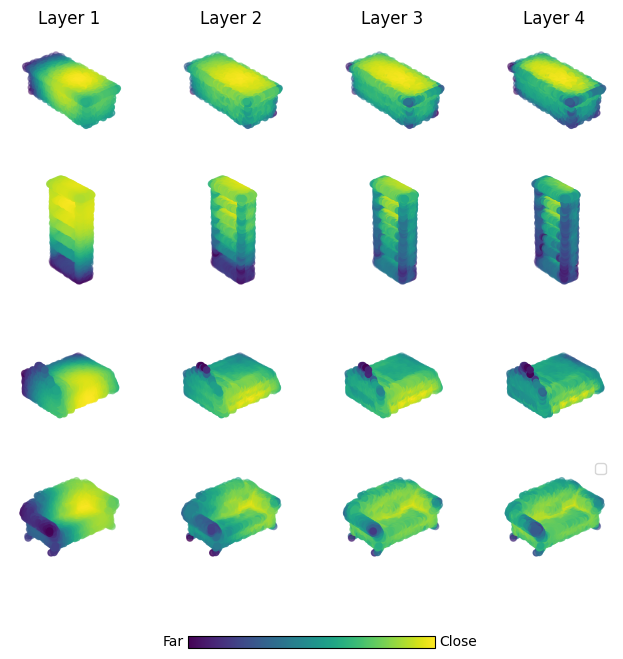

In [5]:
def plot_knn(model, points, idx, device):
    X_points = torch.Tensor(points).to(device)
    _, knn_idx = model(X_points.permute(0, 2, 1), return_idx=True)

    X_points = X_points.squeeze().detach().cpu().numpy()
    nb_plot = X_points.shape[0]
    nb_step = len(knn_idx)

    fig, ax = plt.subplots(ncols=nb_step, nrows=nb_plot, figsize=(2*nb_step, 2*nb_plot), subplot_kw=dict(projection='3d'))

    for plot in range(nb_plot):
        for step, step_knn_idx in enumerate(knn_idx):
            step_knn_idx = step_knn_idx.squeeze().detach().cpu().numpy()
            color = ax[plot,step].scatter(X_points[plot,:, 0], X_points[plot,:, 2], X_points[plot,:, 1], c=-step_knn_idx[plot,idx], marker='o')
            ax[plot,step].scatter(X_points[plot,idx, 0], X_points[plot,idx, 2], X_points[plot,idx, 1], c='r', marker='^')
            ax[plot,step].set_aspect('equal', adjustable='box')
            ax[plot,step].axis('off')
            ax[plot,step].view_init(azim=140, elev=30)
            ax[0,step].set_title(f'Layer {step+1}')
    
    cbar = fig.colorbar(color, ax=ax, orientation='horizontal', fraction=0.02, pad=0.1)
    cbar.set_ticks([])
    cbar.ax.text(-0.02, 0.5, "Far", transform=cbar.ax.transAxes, va='center', ha='right')
    cbar.ax.text(1.02, 0.5, "Close", transform=cbar.ax.transAxes, va='center', ha='left')
    plt.legend()
    plt.show()

dataset_idx = [4,5,300,600]
point_idx = 6
X_test_ind = X_train[dataset_idx]
plot_knn(model, X_test_ind, point_idx, device)


/tmp/ipykernel_1042151/2199397099.py:25: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


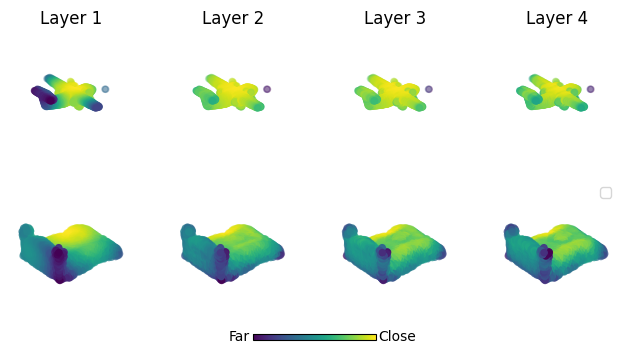

In [ ]:
def plot_knn(model, points, idx, device):
    X_points = torch.Tensor(points).to(device)
    _, knn_idx = model(X_points.permute(0, 2, 1), return_idx=True)

    X_points = X_points.squeeze().detach().cpu().numpy()
    nb_plot = X_points.shape[0]
    nb_step = len(knn_idx)

    fig, ax = plt.subplots(ncols=nb_step, nrows=nb_plot, figsize=(2*nb_step, 2*nb_plot), subplot_kw=dict(projection='3d'))

    for plot in range(nb_plot):
        for step, step_knn_idx in enumerate(knn_idx):
            step_knn_idx = step_knn_idx.squeeze().detach().cpu().numpy()
            color = ax[plot,step].scatter(X_points[plot,:, 0], X_points[plot,:, 2], X_points[plot,:, 1], c=-step_knn_idx[plot,idx], marker='o')
            ax[plot,step].scatter(X_points[plot,idx, 0], X_points[plot,idx, 2], X_points[plot,idx, 1], c='r', marker='^')
            ax[plot,step].set_aspect('equal', adjustable='box')
            ax[plot,step].axis('off')
            ax[plot,step].view_init(azim=140, elev=30)
            ax[0,step].set_title(f'Layer {step+1}')
    
    cbar = fig.colorbar(color, ax=ax, orientation='horizontal', fraction=0.02, pad=0.1)
    cbar.set_ticks([])
    cbar.ax.text(-0.02, 0.5, "Far", transform=cbar.ax.transAxes, va='center', ha='right')
    cbar.ax.text(1.02, 0.5, "Close", transform=cbar.ax.transAxes, va='center', ha='left')
    plt.legend()
    plt.show()

dataset_idx = [8,10]
point_idx = 30
X_test_ind = X_train[dataset_idx]
plot_knn(model, X_test_ind, point_idx, device)

# Object segmentation

In [2]:
X, label, y = load_data_partseg()
print(X.shape, label.shape, y.shape)

(2874, 2048, 3) (2874, 1) (2874, 2048)


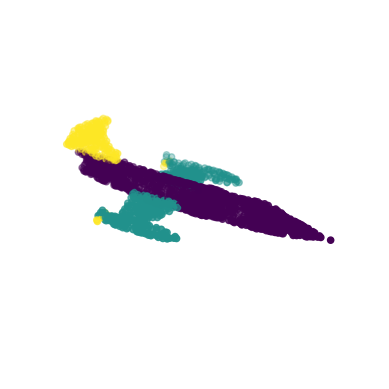

In [3]:
ind = 4
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[ind,:,0], X[ind,:,2], X[ind,:,1], c=y[ind])
ax.set_aspect('equal', adjustable='box')
ax.axis('off')
plt.show()

In [4]:
model = DGCNN_partseg(k=40, emb_dims=1024, dropout=0.5, seg_num_all=50)
num=0
for param in model.parameters():
    if param.requires_grad:
        num += param.numel()
print("Number of parameters in DGCNN: ", num)

state_dict = torch.load('src/dgcnn/pretrained/model.partseg.t7', weights_only=True)
# Convert all keys from module.bn1.weight to bn1.weight
state_dict = {k[7:]: v for k, v in state_dict.items()}
model.load_state_dict(state_dict)
model = nn.DataParallel(model)
model.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

Number of parameters in DGCNN:  1460361


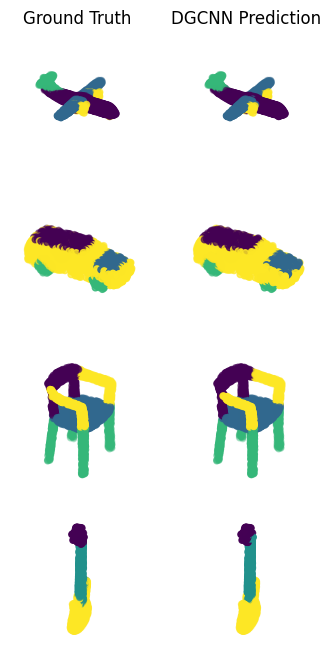

In [8]:
ind = [200, 500, 800, 1400]
X_ind, label_ind, y_ind = X[ind], label[ind], y[ind]
X_ind = torch.Tensor(X_ind).permute(0, 2, 1).to(device)
label_ind = torch.Tensor(label_ind)
label_ind = torch.nn.functional.one_hot(label_ind.to(torch.int64), num_classes=16).float().to(device)
seg_pred = model(X_ind, label_ind).permute(0, 2, 1).squeeze().detach().cpu().numpy()
seg_pred = seg_pred.argmax(axis=2)

fig, ax = plt.subplots(ncols=2, nrows=len(ind), figsize=(4, 2*len(ind)), subplot_kw=dict(projection='3d'))
for i in range(len(ind)):
    ax[i,0].scatter(X[ind[i]][:,0], X[ind[i]][:,2], X[ind[i]][:,1], c=y[ind[i]])
    ax[i,0].set_aspect('equal', adjustable='box')
    ax[i,0].axis('off')
    ax[i,1].scatter(X[ind[i]][:,0], X[ind[i]][:,2], X[ind[i]][:,1], c=seg_pred[i])
    ax[i,1].set_aspect('equal', adjustable='box')
    ax[i,1].axis('off')
# A title for each column
ax[0,0].set_title("Ground Truth")
ax[0,1].set_title("DGCNN Prediction")
plt.show()

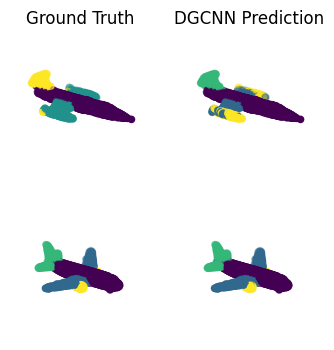

In [9]:
ind = [4,5]
X_ind, label_ind, y_ind = X[ind], label[ind], y[ind]
X_ind = torch.Tensor(X_ind).permute(0, 2, 1).to(device)
label_ind = torch.Tensor(label_ind)
label_ind = torch.nn.functional.one_hot(label_ind.to(torch.int64), num_classes=16).float().to(device)
seg_pred = model(X_ind, label_ind).permute(0, 2, 1).squeeze().detach().cpu().numpy()
seg_pred = seg_pred.argmax(axis=2)

fig, ax = plt.subplots(ncols=2, nrows=len(ind), figsize=(4, 2*len(ind)), subplot_kw=dict(projection='3d'))
for i in range(len(ind)):
    ax[i,0].scatter(X[ind[i]][:,0], X[ind[i]][:,2], X[ind[i]][:,1], c=y[ind[i]])
    ax[i,0].set_aspect('equal', adjustable='box')
    ax[i,0].axis('off')
    ax[i,1].scatter(X[ind[i]][:,0], X[ind[i]][:,2], X[ind[i]][:,1], c=seg_pred[i])
    ax[i,1].set_aspect('equal', adjustable='box')
    ax[i,1].axis('off')
# A title for each column
ax[0,0].set_title("Ground Truth")
ax[0,1].set_title("DGCNN Prediction")
plt.show()


# Scene segmentation

In [8]:
X, color, y = load_data_semseg()
print(X.shape, color.shape, y.shape)

(68, 289724, 3) (68, 289724, 3) (68, 289724)


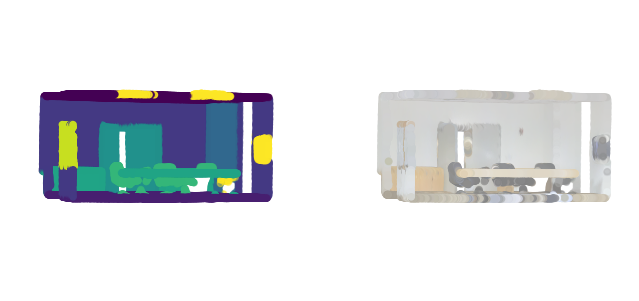

In [ ]:
ind = 4
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(4*2, 4), subplot_kw=dict(projection='3d'))
ax[0].scatter(X[ind,:40000, 0], X[ind,:40000, 1], X[ind,:40000, 2], c=y[ind,:40000])
ax[0].set_aspect('equal', adjustable='box')
ax[0].view_init(azim=160, elev=0)
ax[0].axis('off')
ax[1].scatter(X[ind,:40000, 0], X[ind,:40000, 1], X[ind,:40000, 2], c=(color[ind,:40000,:]/255.0 + 1)/2)
ax[1].set_aspect('equal', adjustable='box')
ax[1].view_init(azim=160, elev=0)
ax[1].axis('off')
plt.show()